In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import gzip
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time

(60000, 784)

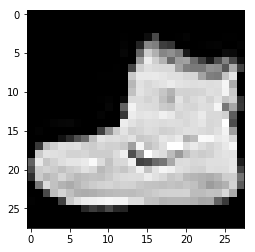

In [2]:
with gzip.open('./data/fashion-mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    mnist_data = np.frombuffer(f.read(), np.uint8, offset=16)
    mnist_data = mnist_data.reshape(-1, 784)
    
mnist_data = mnist_data / np.max(mnist_data)
    
plt.imshow(mnist_data[0].reshape([28,28]), cmap='gray')
mnist_data.shape

In [3]:
with gzip.open('./data/fashion-mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    mnist_label = np.frombuffer(f.read(), np.uint8, offset=8)

print(mnist_label.shape)
len(np.unique(mnist_label))

(60000,)


10

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data, mnist_label, test_size=0.33)

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()

X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).long()

print('Train shape : ',X_train.shape, Y_train.shape,
     '\nTest shape : ',X_test.shape, Y_test.shape)

Train shape :  torch.Size([40200, 784]) torch.Size([40200]) 
Test shape :  torch.Size([19800, 784]) torch.Size([19800])


In [5]:
train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train, batch_size = 100, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4*4*64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
#         x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
#         x = F.max_pool2d(x, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net()
model = model.cuda()
torch.backends.cudnn.benchmark=True

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
start = time.time()
for epoch in range(100):
    total_loss = 0
    for data, target in train_loader:
        x_train, y_train = Variable(data.reshape(-1,1,28,28)).cuda(), Variable(target).cuda()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    if (epoch + 1) % 2 == 0:
        print(epoch+1, total_loss)
end = time.time()
print('Elapsed time : %.3f' % (end-start))

C:\Users\my\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2 328.63032680749893
4 258.30868449807167
6 227.80106019973755
8 207.12918850779533
10 192.4823879301548
12 180.51417788863182
14 171.03073662519455
16 163.0551644563675
18 155.5251849591732
20 150.1714456230402
22 144.79426337778568
24 140.68986804783344
26 136.1021412461996
28 132.5209854990244
30 129.35393151640892
32 125.39096157252789
34 122.79280537366867
36 120.0080553740263
38 117.41890934109688
40 115.23605398833752
42 112.95709224790335
44 110.45081475377083
46 107.99478623270988
48 105.84284710139036
50 104.1241666674614
52 101.80544673651457
54 100.11492568999529
56 98.54342740029097
58 96.4520677626133
60 94.50572993606329
62 93.51631157845259
64 91.6001613587141
66 89.22082839161158
68 87.91053934395313
70 85.694853939116
72 84.53275460749865
74 82.7215255945921
76 81.35594079643488
78 79.35403713956475
80 77.8212813064456
82 76.85183221846819
84 75.07353401184082
86 74.06944736093283
88 71.9874314814806
90 70.51908425986767
92 69.09872995316982
94 68.03042073175311
96 66

In [11]:
x_test, y_test = Variable(X_test.float()).cuda(), Variable(Y_test.long()).cuda()
x_test = x_test.reshape(-1, 1, 28, 28)

In [12]:
result = torch.max(model(x_test[:15000]).data, 1)[1]
accuracy = sum(result.cpu().numpy() == y_test[:15000].cpu().numpy()) / len(y_test[:15000].cpu().numpy())
accuracy

C:\Users\my\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.897